In [22]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import numpy as np
import torch as t
import tqdm
#functional
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [14]:
potential_moves = 10
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=potential_moves+1,
    d_vocab_out=potential_moves,
    n_ctx=10,
    init_weights=True,
    device="cuda",
    seed = 999,
)

lr = 1e-3
weight_decay = 1e-4
test_train_split = 0.8
epochs = 10
batch_size = 4096



In [15]:
#load npy file
np_data = np.load('data/moves.npy')
data = [sequence[i: i+potential_moves] for sequence in np_data for i in range(len(sequence)-potential_moves)]
labels = [sequence[i+potential_moves] for sequence in np_data for i in range(len(sequence)-potential_moves)]

print(len(data))
print(len(labels))
print(data[1])
print(labels)

460800
460800
[10 10 10 10 10 10 10 10 10  0]
[0, 1, 2, 3, 4, 6, 5, 8, 7, 9, 0, 1, 2, 3, 4, 6, 7, 8, 5, 9, 0, 1, 2, 3, 4, 8, 5, 6, 7, 9, 0, 1, 2, 3, 4, 8, 7, 6, 5, 9, 0, 1, 2, 3, 5, 4, 6, 8, 7, 9, 0, 1, 2, 3, 5, 4, 7, 8, 6, 9, 0, 1, 2, 3, 5, 6, 4, 8, 7, 9, 0, 1, 2, 3, 5, 6, 7, 8, 4, 9, 0, 1, 2, 3, 5, 8, 4, 6, 7, 9, 0, 1, 2, 3, 5, 8, 6, 4, 7, 9, 0, 1, 2, 3, 5, 8, 7, 4, 6, 9, 0, 1, 2, 3, 5, 8, 7, 6, 4, 9, 0, 1, 2, 3, 6, 4, 5, 8, 7, 9, 0, 1, 2, 3, 6, 4, 7, 8, 5, 9, 0, 1, 2, 3, 6, 8, 5, 4, 7, 9, 0, 1, 2, 3, 6, 8, 7, 4, 5, 9, 0, 1, 2, 3, 7, 4, 5, 8, 6, 9, 0, 1, 2, 3, 7, 4, 6, 8, 5, 9, 0, 1, 2, 3, 7, 6, 4, 8, 5, 9, 0, 1, 2, 3, 7, 6, 5, 8, 4, 9, 0, 1, 2, 3, 7, 8, 4, 6, 5, 9, 0, 1, 2, 3, 7, 8, 5, 4, 6, 9, 0, 1, 2, 3, 7, 8, 5, 6, 4, 9, 0, 1, 2, 3, 7, 8, 6, 4, 5, 9, 0, 1, 2, 4, 3, 5, 7, 6, 8, 9, 0, 1, 2, 4, 3, 5, 8, 6, 7, 9, 0, 1, 2, 4, 3, 6, 5, 8, 7, 9, 0, 1, 2, 4, 3, 6, 7, 5, 8, 9, 0, 1, 2, 4, 3, 6, 7, 8, 5, 9, 0, 1, 2, 4, 3, 6, 8, 5, 7, 9, 0, 1, 2, 4, 3, 8, 5, 6, 7, 9, 0, 1, 2, 4, 3, 8, 7, 6,

In [16]:
encoded_labels = F.one_hot(t.tensor(labels))
print(encoded_labels)
print(t.sum(encoded_labels, axis=1))

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1]])
tensor([1, 1, 1,  ..., 1, 1, 1])


In [17]:
#data and labels as numpy arrays
data = np.array(data)
encoded_labels = np.array(encoded_labels)
#data and encoded_labels as tensors
data = t.from_numpy(data).to(cfg.device)
encoded_labels = t.from_numpy(encoded_labels).to(cfg.device)

In [18]:
#test train split
train_data = data[:int(len(data)*test_train_split)]
train_labels = encoded_labels[:int(len(data)*test_train_split)]
test_data = data[int(len(data)*test_train_split):]
test_labels = encoded_labels[int(len(data)*test_train_split):]

In [19]:
print(len(test_data))
print(len(test_labels))

92160
92160


In [20]:
def loss_fn(logits, labels):
    return t.nn.functional.cross_entropy(logits, labels)

In [21]:
train_losses = []
test_losses = []
model = HookedTransformer(cfg).to(cfg.device)
optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in tqdm.tqdm(range(epochs)):
    for batch in range(0, len(train_data), batch_size):
        train_logits = model(train_data[batch:batch+batch_size])
        train_loss = loss_fn(train_logits, train_labels[batch:batch+batch_size])

        train_loss.backward()

        train_losses.append(train_loss.item())
        optimizer.step()
        optimizer.zero_grad()

        with t.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        print(f"Epoch {epoch} | Train Loss: {train_loss.item()} | Test Loss: {test_loss.item()}")

Moving model to device:  cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 2.3078410625457764 | Test Loss: 2.190394163131714
Epoch 0 | Train Loss: 2.1895737648010254 | Test Loss: 2.0778939723968506
Epoch 0 | Train Loss: 2.0789434909820557 | Test Loss: 1.9556277990341187
Epoch 0 | Train Loss: 1.9567533731460571 | Test Loss: 1.819016933441162
Epoch 0 | Train Loss: 1.821606993675232 | Test Loss: 1.6625107526779175
Epoch 0 | Train Loss: 1.6618025302886963 | Test Loss: 1.4820077419281006
Epoch 0 | Train Loss: 1.4787417650222778 | Test Loss: 1.2768360376358032
Epoch 0 | Train Loss: 1.2722243070602417 | Test Loss: 1.0537525415420532
Epoch 0 | Train Loss: 1.0512564182281494 | Test Loss: 0.83296138048172
Epoch 0 | Train Loss: 0.8272544741630554 | Test Loss: 0.6406683325767517
Epoch 0 | Train Loss: 0.6363641023635864 | Test Loss: 0.5074436664581299
Epoch 0 | Train Loss: 0.5043699145317078 | Test Loss: 0.44494128227233887
Epoch 0 | Train Loss: 0.44453686475753784 | Test Loss: 0.43973854184150696
Epoch 0 | Train Loss: 0.44525623321533203 | Test Loss

 10%|█         | 1/10 [00:05<00:48,  5.35s/it]

Epoch 0 | Train Loss: 0.28437456488609314 | Test Loss: 0.2842046022415161
Epoch 0 | Train Loss: 0.28424620628356934 | Test Loss: 0.2840139865875244
Epoch 1 | Train Loss: 0.2839275002479553 | Test Loss: 0.28395506739616394
Epoch 1 | Train Loss: 0.2837681472301483 | Test Loss: 0.28381434082984924
Epoch 1 | Train Loss: 0.28377771377563477 | Test Loss: 0.2836724817752838
Epoch 1 | Train Loss: 0.2836301922798157 | Test Loss: 0.2836790680885315
Epoch 1 | Train Loss: 0.2835718095302582 | Test Loss: 0.28367188572883606
Epoch 1 | Train Loss: 0.2835840582847595 | Test Loss: 0.2837071120738983
Epoch 1 | Train Loss: 0.2834574282169342 | Test Loss: 0.28364118933677673
Epoch 1 | Train Loss: 0.28347891569137573 | Test Loss: 0.2836492359638214
Epoch 1 | Train Loss: 0.28335657715797424 | Test Loss: 0.28356608748435974
Epoch 1 | Train Loss: 0.2833130657672882 | Test Loss: 0.2834845185279846
Epoch 1 | Train Loss: 0.28335314989089966 | Test Loss: 0.2834441065788269
Epoch 1 | Train Loss: 0.2832352221012115

 20%|██        | 2/10 [00:10<00:42,  5.35s/it]

Epoch 1 | Train Loss: 0.2827453911304474 | Test Loss: 0.2828877866268158
Epoch 2 | Train Loss: 0.2827741205692291 | Test Loss: 0.28288695216178894
Epoch 2 | Train Loss: 0.2826850414276123 | Test Loss: 0.28280124068260193
Epoch 2 | Train Loss: 0.28276023268699646 | Test Loss: 0.28279614448547363
Epoch 2 | Train Loss: 0.2826772928237915 | Test Loss: 0.2827942967414856
Epoch 2 | Train Loss: 0.2826710641384125 | Test Loss: 0.28279879689216614
Epoch 2 | Train Loss: 0.28274306654930115 | Test Loss: 0.28277888894081116
Epoch 2 | Train Loss: 0.2826603055000305 | Test Loss: 0.28278300166130066
Epoch 2 | Train Loss: 0.2827295660972595 | Test Loss: 0.28277987241744995
Epoch 2 | Train Loss: 0.2826572060585022 | Test Loss: 0.2827794551849365
Epoch 2 | Train Loss: 0.28265100717544556 | Test Loss: 0.28277865052223206
Epoch 2 | Train Loss: 0.2827203571796417 | Test Loss: 0.28276532888412476
Epoch 2 | Train Loss: 0.28264302015304565 | Test Loss: 0.28276515007019043
Epoch 2 | Train Loss: 0.2827429175376

 30%|███       | 3/10 [00:16<00:37,  5.36s/it]

Epoch 2 | Train Loss: 0.28261253237724304 | Test Loss: 0.28276556730270386
Epoch 2 | Train Loss: 0.2826184630393982 | Test Loss: 0.2827625572681427
Epoch 3 | Train Loss: 0.2826600670814514 | Test Loss: 0.282759428024292
Epoch 3 | Train Loss: 0.28258204460144043 | Test Loss: 0.2827567160129547
Epoch 3 | Train Loss: 0.282662570476532 | Test Loss: 0.2827529013156891
Epoch 3 | Train Loss: 0.28258565068244934 | Test Loss: 0.2827613651752472
Epoch 3 | Train Loss: 0.28258660435676575 | Test Loss: 0.2827669382095337
Epoch 3 | Train Loss: 0.28265827894210815 | Test Loss: 0.2827626168727875
Epoch 3 | Train Loss: 0.2825815975666046 | Test Loss: 0.2827596068382263
Epoch 3 | Train Loss: 0.282656729221344 | Test Loss: 0.2827598452568054
Epoch 3 | Train Loss: 0.28258150815963745 | Test Loss: 0.28276029229164124
Epoch 3 | Train Loss: 0.28257501125335693 | Test Loss: 0.2827605605125427
Epoch 3 | Train Loss: 0.2826518416404724 | Test Loss: 0.2827593684196472
Epoch 3 | Train Loss: 0.28257542848587036 | T

 40%|████      | 4/10 [00:21<00:32,  5.36s/it]

Epoch 3 | Train Loss: 0.28257623314857483 | Test Loss: 0.2827428877353668
Epoch 4 | Train Loss: 0.2826319932937622 | Test Loss: 0.2827379107475281
Epoch 4 | Train Loss: 0.28255364298820496 | Test Loss: 0.2827383875846863
Epoch 4 | Train Loss: 0.28263047337532043 | Test Loss: 0.2827425003051758
Epoch 4 | Train Loss: 0.2825591266155243 | Test Loss: 0.2827432453632355
Epoch 4 | Train Loss: 0.2825520634651184 | Test Loss: 0.28274306654930115
Epoch 4 | Train Loss: 0.28262943029403687 | Test Loss: 0.28273314237594604
Epoch 4 | Train Loss: 0.2825547158718109 | Test Loss: 0.2827330231666565
Epoch 4 | Train Loss: 0.28263214230537415 | Test Loss: 0.2827354371547699
Epoch 4 | Train Loss: 0.2825489044189453 | Test Loss: 0.28273388743400574
Epoch 4 | Train Loss: 0.2825530469417572 | Test Loss: 0.2827375531196594
Epoch 4 | Train Loss: 0.28263118863105774 | Test Loss: 0.2827356159687042
Epoch 4 | Train Loss: 0.2825564742088318 | Test Loss: 0.28273701667785645
Epoch 4 | Train Loss: 0.2826399505138397 

 50%|█████     | 5/10 [00:26<00:26,  5.35s/it]

Epoch 4 | Train Loss: 0.2825576961040497 | Test Loss: 0.28273001313209534
Epoch 4 | Train Loss: 0.28255805373191833 | Test Loss: 0.2827287018299103
Epoch 5 | Train Loss: 0.28261977434158325 | Test Loss: 0.28272855281829834
Epoch 5 | Train Loss: 0.2825423777103424 | Test Loss: 0.282725065946579
Epoch 5 | Train Loss: 0.28262069821357727 | Test Loss: 0.2827284634113312
Epoch 5 | Train Loss: 0.2825425863265991 | Test Loss: 0.28273555636405945
Epoch 5 | Train Loss: 0.2825402319431305 | Test Loss: 0.2827340364456177
Epoch 5 | Train Loss: 0.28261658549308777 | Test Loss: 0.2827310562133789
Epoch 5 | Train Loss: 0.2825418710708618 | Test Loss: 0.28273099660873413
Epoch 5 | Train Loss: 0.28262239694595337 | Test Loss: 0.2827303111553192
Epoch 5 | Train Loss: 0.2825404107570648 | Test Loss: 0.28272971510887146
Epoch 5 | Train Loss: 0.28254637122154236 | Test Loss: 0.2827299237251282
Epoch 5 | Train Loss: 0.28262215852737427 | Test Loss: 0.28272947669029236
Epoch 5 | Train Loss: 0.282542854547500

 60%|██████    | 6/10 [00:32<00:21,  5.34s/it]

Epoch 5 | Train Loss: 0.28254997730255127 | Test Loss: 0.2827204167842865
Epoch 6 | Train Loss: 0.28261542320251465 | Test Loss: 0.28271424770355225
Epoch 6 | Train Loss: 0.28254371881484985 | Test Loss: 0.28271540999412537
Epoch 6 | Train Loss: 0.2826128900051117 | Test Loss: 0.28272315859794617
Epoch 6 | Train Loss: 0.28253936767578125 | Test Loss: 0.2827293276786804
Epoch 6 | Train Loss: 0.2825396656990051 | Test Loss: 0.2827238142490387
Epoch 6 | Train Loss: 0.28261128067970276 | Test Loss: 0.28270426392555237
Epoch 6 | Train Loss: 0.2825370728969574 | Test Loss: 0.2827203869819641
Epoch 6 | Train Loss: 0.28261396288871765 | Test Loss: 0.28272420167922974
Epoch 6 | Train Loss: 0.2825384736061096 | Test Loss: 0.2827245891094208
Epoch 6 | Train Loss: 0.28254038095474243 | Test Loss: 0.28272658586502075
Epoch 6 | Train Loss: 0.2826138138771057 | Test Loss: 0.2827194631099701
Epoch 6 | Train Loss: 0.28253817558288574 | Test Loss: 0.2827228903770447
Epoch 6 | Train Loss: 0.2826168537139

 70%|███████   | 7/10 [00:37<00:16,  5.34s/it]

Epoch 6 | Train Loss: 0.2825411260128021 | Test Loss: 0.2826352119445801
Epoch 6 | Train Loss: 0.28254368901252747 | Test Loss: 0.2826319634914398
Epoch 7 | Train Loss: 0.2826154828071594 | Test Loss: 0.28263506293296814
Epoch 7 | Train Loss: 0.28253668546676636 | Test Loss: 0.28263556957244873
Epoch 7 | Train Loss: 0.28261685371398926 | Test Loss: 0.2826460301876068
Epoch 7 | Train Loss: 0.28253355622291565 | Test Loss: 0.28264135122299194
Epoch 7 | Train Loss: 0.2825348973274231 | Test Loss: 0.2826420068740845
Epoch 7 | Train Loss: 0.28260549902915955 | Test Loss: 0.2826215922832489
Epoch 7 | Train Loss: 0.2825353145599365 | Test Loss: 0.28264525532722473
Epoch 7 | Train Loss: 0.2826085388660431 | Test Loss: 0.2826424539089203
Epoch 7 | Train Loss: 0.2825346887111664 | Test Loss: 0.28262263536453247
Epoch 7 | Train Loss: 0.2825359106063843 | Test Loss: 0.2826363444328308
Epoch 7 | Train Loss: 0.28261226415634155 | Test Loss: 0.2826412320137024
Epoch 7 | Train Loss: 0.2825348973274231

 80%|████████  | 8/10 [00:42<00:10,  5.34s/it]

Epoch 7 | Train Loss: 0.28253301978111267 | Test Loss: 0.2826412618160248
Epoch 8 | Train Loss: 0.28261101245880127 | Test Loss: 0.2826409339904785
Epoch 8 | Train Loss: 0.2825305163860321 | Test Loss: 0.2826409637928009
Epoch 8 | Train Loss: 0.28260794281959534 | Test Loss: 0.28263717889785767
Epoch 8 | Train Loss: 0.2825273871421814 | Test Loss: 0.2826407551765442
Epoch 8 | Train Loss: 0.2825278639793396 | Test Loss: 0.28262174129486084
Epoch 8 | Train Loss: 0.282610684633255 | Test Loss: 0.2826361656188965
Epoch 8 | Train Loss: 0.28253093361854553 | Test Loss: 0.2826436161994934
Epoch 8 | Train Loss: 0.2826094329357147 | Test Loss: 0.28263989090919495
Epoch 8 | Train Loss: 0.282530814409256 | Test Loss: 0.28264451026916504
Epoch 8 | Train Loss: 0.28252938389778137 | Test Loss: 0.28264319896698
Epoch 8 | Train Loss: 0.28260356187820435 | Test Loss: 0.2826385498046875
Epoch 8 | Train Loss: 0.2825295627117157 | Test Loss: 0.2826448082923889
Epoch 8 | Train Loss: 0.2826116681098938 | Te

 90%|█████████ | 9/10 [00:48<00:05,  5.34s/it]

Epoch 8 | Train Loss: 0.28253644704818726 | Test Loss: 0.2826337516307831
Epoch 8 | Train Loss: 0.28253811597824097 | Test Loss: 0.28262653946876526
Epoch 9 | Train Loss: 0.2826024889945984 | Test Loss: 0.282639741897583
Epoch 9 | Train Loss: 0.282529354095459 | Test Loss: 0.28261899948120117
Epoch 9 | Train Loss: 0.2826090157032013 | Test Loss: 0.2826360762119293
Epoch 9 | Train Loss: 0.2825271785259247 | Test Loss: 0.2826337218284607
Epoch 9 | Train Loss: 0.28253263235092163 | Test Loss: 0.2826226055622101
Epoch 9 | Train Loss: 0.2826070189476013 | Test Loss: 0.2826378643512726
Epoch 9 | Train Loss: 0.2825313210487366 | Test Loss: 0.28263533115386963
Epoch 9 | Train Loss: 0.2826090455055237 | Test Loss: 0.282639741897583
Epoch 9 | Train Loss: 0.2825286090373993 | Test Loss: 0.2826397120952606
Epoch 9 | Train Loss: 0.282528281211853 | Test Loss: 0.2826399803161621
Epoch 9 | Train Loss: 0.282605916261673 | Test Loss: 0.2826383411884308
Epoch 9 | Train Loss: 0.2825254797935486 | Test Lo

100%|██████████| 10/10 [00:53<00:00,  5.34s/it]

Epoch 9 | Train Loss: 0.2825343608856201 | Test Loss: 0.28263503313064575


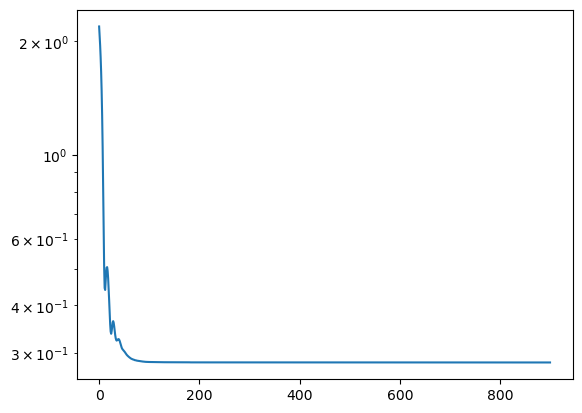

In [31]:
plt.semilogy(test_losses)
# plt.plot(train_losses)

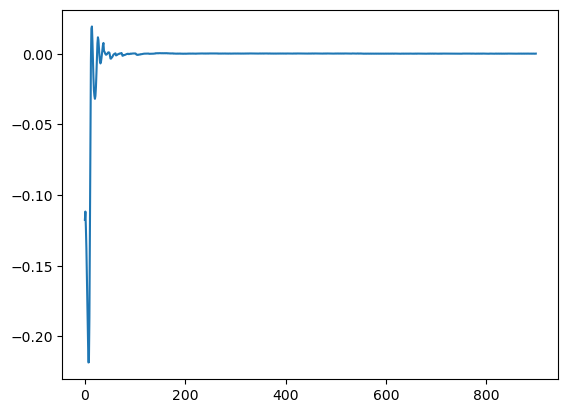

In [27]:
plt.plot(t.tensor(test_losses)-t.tensor(train_losses))
